In [44]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

macro_nutrients = [
              'kcal per 100 g ready to eat',
              'Protein_(g)',
              'Lipid_Tot_(g)',
              'FA_Sat_(g)',
              'Carbohydrt_(g)']

micro_nutrients = [
              'Fiber_TD_(g)',
              'Vit_A_RAE',
              'Vit_B6_(mg)',
              'Vit_B12_(mcg)',
              'Vit_C_(mg)',
              'Vit_E_(mg)',
              'Folate_DFE_(mcg)',
              'Vit_K_(mcg)',
              'Riboflavin_(mg)',
              'Calcium_(mg)',
              'Niacin_(mg)',
              'Cholestrl_(mg)',
              'FA_Mono_(g)',
              'FA_Poly_(g)',
              'Sugar_Tot_(g)',
              'soluble fiber',
              'total Flavonoid',
              'Iron_(mg)',
              'Alpha_Carot_(mcg)',
              'Beta_Carot_(mcg)',
              'Lycopene_(mcg)',
              'Lut+Zea_(mcg)',
              'Beta_Crypt_(mcg)',
              'Sodium_(mg)',
              'Selenium_(mcg)',
              'Potassium_(mg)',
              'Phytosterols(mg)Per 100 g']

nutrient_list = macro_nutrients + micro_nutrients

food_abbrev = ['almond',
                'apples',
                'apricot',
                'asparag.',
                'avocado',
                'banana',
                'barley',
                'kidney bn.',
                'snap bn.',
                'blueberry',
                'broccoli',
                'cabbage',
                'canola oil',
                'cantaloupe',
                'carrots',
                'cauliflower',
                'celery',
                'cherry',
                'collard',
                'corn flr',
                'corn starch',
                'corn grits',
                'swt corn',
                'cucumber',
                'garlic',
                'grapefruit',
                'grapes',
                'hazelnuts',
                'honeydew',
                'kiwi',
                'lemon',
                'lettuce',
                'macadam.',       
                'oats',            
                'olive oil',       
                'onions',          
                'orange',          
                'peach',           
                'peanut',         
                'pear',            
                'peas',            
                'grn pepper',     
                'pineapple',       
                'pistachio',       
                'potato',          
                'pumpkin',         
                'raspberry',     
                'rice',            
                'soy oil',         
                'spinach',         
                'squash',          
                'strawberry',    
                'sweet potato',    
                'tomato',        
                'walnut',         
                'watermelon',      
                'wheat',           
                'chickpeas',       
                'lentils',         
                'soybeans',        
                'tofu',            
                'buckwheat',   
                'sorghum',
                'rye',             
                'spelt',           
                'saflwer oil',
                'syrup cane',
                'hfcs'
                ]

ANIMALS =      ['beef',
                'dairy',
                'egg',
                'chicken',
                'pork',
                'salmon',
                'tuna']

food_abbrev += ANIMALS

UDSA_COLNAME = 'USDA groups'
MAD_COLNAME = 'MAD (kcal/cap/d)'
ENERGY_COLNAME = 'Energ_Kcal'
data_frame = pd.DataFrame.from_csv('plVals.csv')
index2abbrev = dict(zip(data_frame.index, food_abbrev))
data_frame = data_frame.rename(index=index2abbrev)
#data_frame[pd.isnull(data_frame)] = 0

# find the corresponding index of the columns in the dataframe to the nutrient list.
# it is enough of the prefix of the column name matches exactly the nutrien name
col_names = list(data_frame.columns)
col_ind_order = np.zeros((1, len(nutrient_list)))
nutrient_list_updated = [''] * len(nutrient_list)
for i, nutr in enumerate(nutrient_list):
    for j, col in enumerate(col_names):
        l_min = min(len(nutr), len(col))
        if nutr[:l_min] == col[:l_min]:
            col_ind_order[0, i] = j
            nutrient_list_updated[i] = col
            continue
nutrient_list = nutrient_list_updated
data = data_frame[nutrient_list]
usda_group = data_frame[UDSA_COLNAME]

# correct to eaten mass basis, so that D entries will be in "per g ready2eat"
data.loc[:, nutrient_list[0]] = data[[nutrient_list[0]]] * 0.01 # convert first column from kcal/100g to kcal/g
for nutr in nutrient_list[1:]:
    # divide by kcal per g / kcal per g ready2eat
    data.loc[:, nutr] *= data.loc[:, nutrient_list[0]] / data_frame.loc[:, ENERGY_COLNAME]

# calculate how many grams of a certain animal-based food product is consumed in MAD
animal = 'egg'
MADg = data_frame.loc[animal, MAD_COLNAME] / data.loc[animal, nutrient_list[0]]
print '%.1f grams of %s are in MAD per day' % (MADg, animal)

# then calculate how many of each nutrient is provided by this animal-based food
b = data.loc[animal, :] * MADg

data_normalized = data.copy()
for food in data.index:
    # divide by kcal per g / kcal per g ready2eat
    data_normalized.loc[food, :] *= 100.0 / b

# make a table which holds how much of the <<total>> daily requirement of each
# micronutrient (the amount provided by the selected animal-based food) is
# given by 1 gram of each plant-based food.
micro_in_percent = data_normalized[nutrient_list[5:]] * 100
micro_in_percent[micro_in_percent > 100] = 100
micro_in_percent[pd.isnull(micro_in_percent)] = 100
data_normalized['satisfied micronutrient'] = micro_in_percent.mean(axis=1)

24.3 grams of egg are in MAD per day


In [45]:
from matplotlib.transforms import offset_copy

def scatterplot(data, x, y):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(1, 1, 1)
    transOffset = offset_copy(ax.transData, fig=fig, y=6, units='dots')
    data.plot(x, y, kind='scatter', ax=ax, color='g')
    data.loc[ANIMALS, :].plot(x, y, kind='scatter', ax=ax, color='r')

    for i in list(data.index):
        if i in ANIMALS:
            ax.text(data[x][i], data[y][i], i, fontsize=12, color='r',
                    transform=transOffset, horizontalalignment='center',
                    verticalalignment='bottom')
        else:
            ax.text(data[x][i], data[y][i], i, fontsize=10, color='g',
                    transform=transOffset, horizontalalignment='center',
                    verticalalignment='bottom')


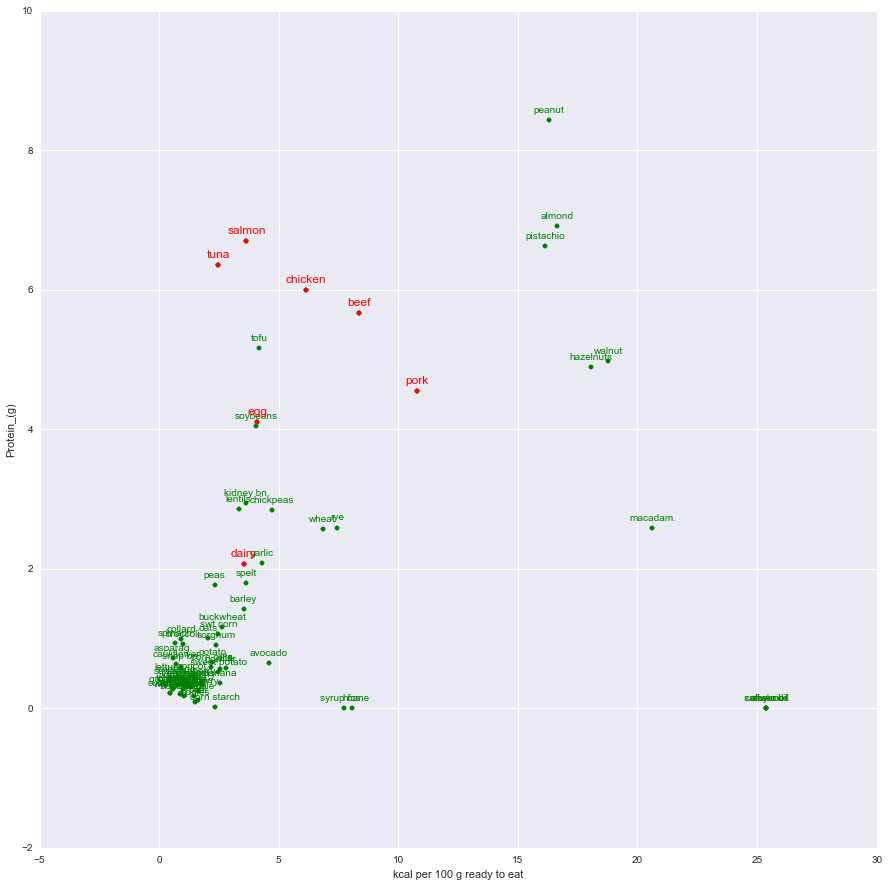

In [47]:
scatterplot(data_normalized, nutrient_list[0], nutrient_list[1])

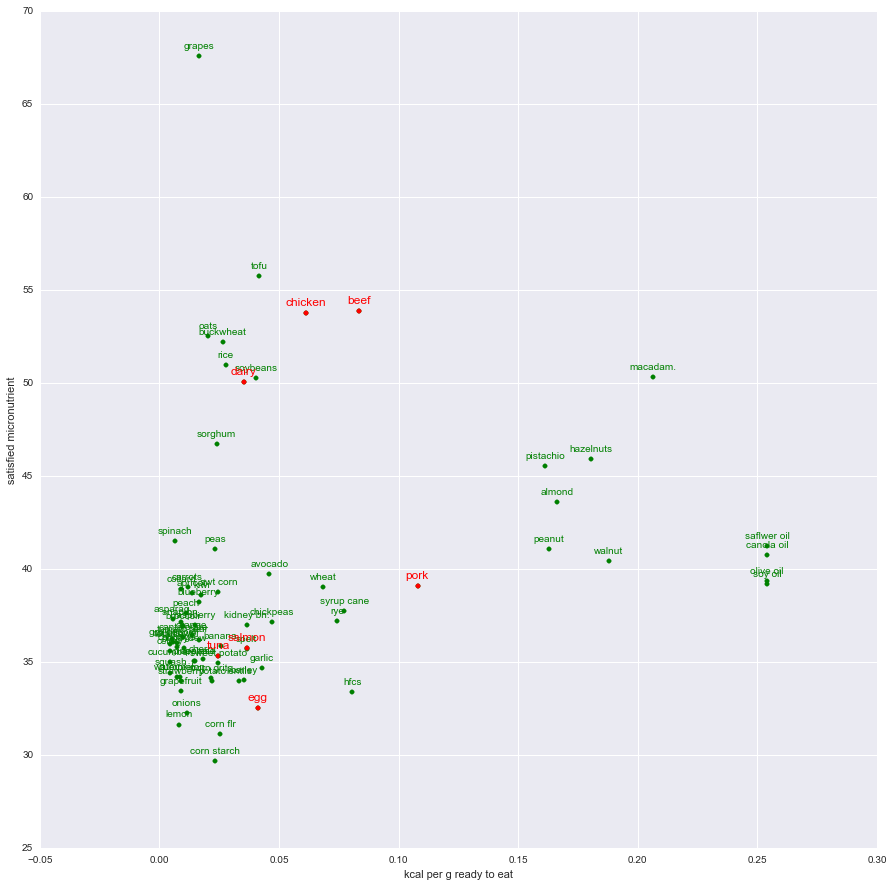

In [36]:
scatterplot(data_normalized, nutrient_list[0], 'satisfied micronutrient')

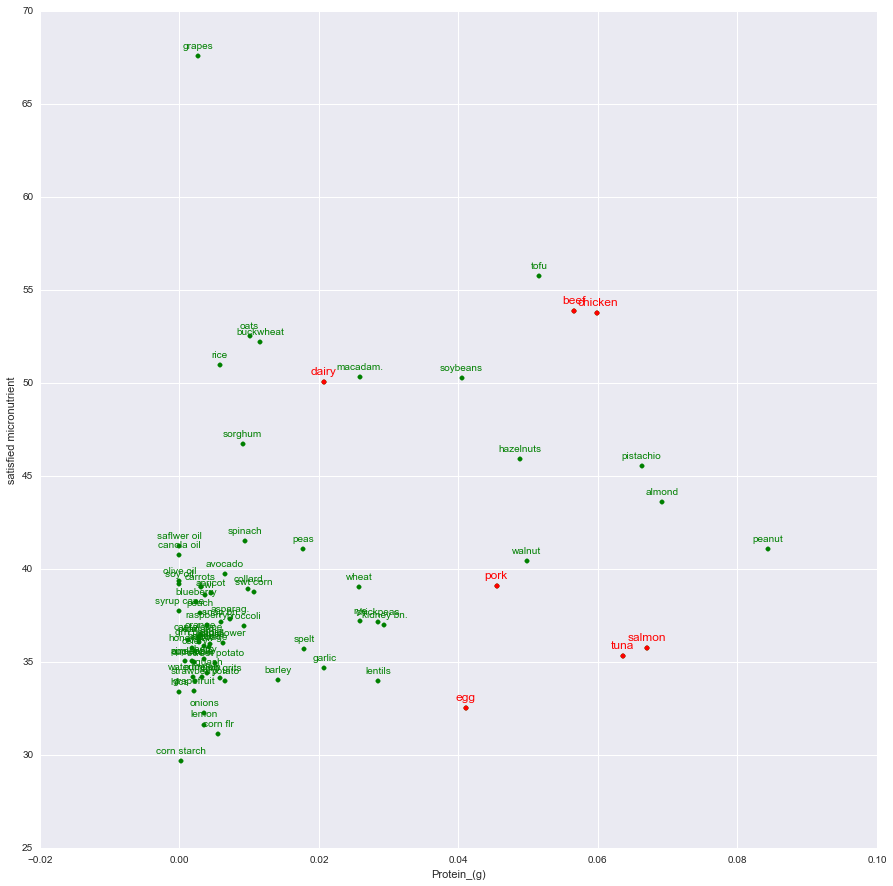

In [37]:
scatterplot(data_normalized, nutrient_list[1], 'satisfied micronutrient')

In [14]:
print data.loc[['spinach','tofu','egg'],nutrient_list[0:2]]


                                      kcal per g ready to eat  Protein_(g)
 Values per 100 g edible g Shrt_Desc                                      
spinach                                                  0.23       0.0286
tofu                                                     1.45       0.1578
egg                                                      1.43       0.1256
